In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import intodf
from matplotlib.colors import LinearSegmentedColormap

EDA
1. plot the expert labels for the presence or absence of clouds

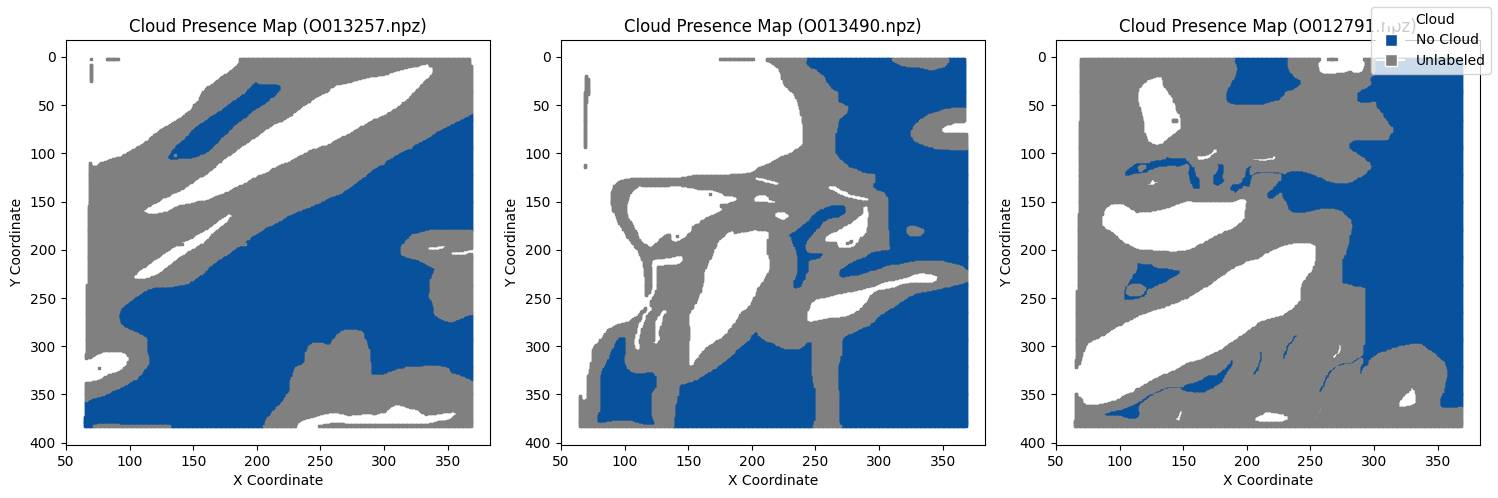

In [3]:
exp_files = ["O013257.npz", "O013490.npz", "O012791.npz"]

color_map = {1: "white", -1: "#08519c", 0: "gray"}
label_names = {1: "Cloud", -1: "No Cloud", 0: "Unlabeled"}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, file in enumerate(exp_files):
    df = intodf(file)
    y = df['Y']
    x = df['X']
    labels = df["label"]

    ax = axes[i]
    for label, color in color_map.items():
        mask = labels == label  # Define mask
        ax.scatter(x[mask], y[mask], c=color, s=1, marker='s', label=label_names[label])

    ax.invert_yaxis()
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Cloud Presence Map ({file})")

handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_map[label], markersize=8, label=label_names[label]) for label in color_map]
fig.legend(handles=handles, loc="upper right")

plt.tight_layout() 
plt.savefig('../figs/EDA/EDA01.png', bbox_inches='tight')
plt.show()


2. Explore the relationships between the radiances of different angles, both visually and quantitatively

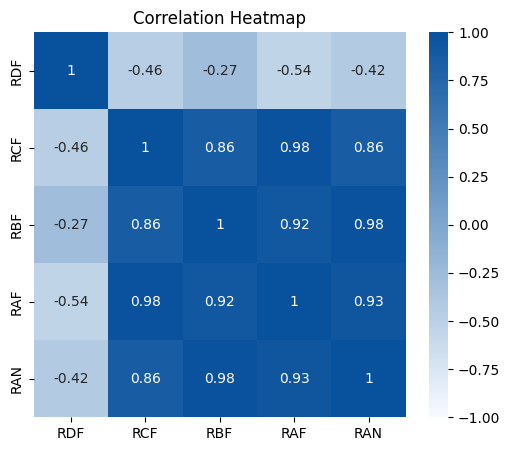

In [4]:
# First make the labeled three pictures into one dataframe : df_labeled.
df_labeled = pd.DataFrame()
for i, file in enumerate(exp_files):
    df1 = intodf(file)
    df_labeled = pd.concat([df_labeled, df1])

colors = ["#f7fbff", "#08519c"]
custom_cmap = LinearSegmentedColormap.from_list("custom_blue_gray", colors, N=256)
corr = df_labeled.iloc[5:10,5:10].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap=custom_cmap, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('../figs/EDA/EDA02.png', bbox_inches='tight')
plt.show()

Testing significance of the coefficients for columns

In [6]:
from scipy.stats import ttest_ind
columns_to_compare = ['RDF', 'RCF', 'RBF', 'RAF', 'RAN', 'NDAI', 'SD', 'CORR']
results = []

for col in columns_to_compare:
    group0 = df_labeled[df_labeled['label'] == -1][col]
    group1 = df_labeled[df_labeled['label'] == 1][col]
    t_stat, p_value = ttest_ind(group0, group1)
    results.append({
        'Column': col,
        'T-statistic': t_stat,
        'P-value': p_value
    })

results_df = pd.DataFrame(results)
print(results_df)

  Column  T-statistic        P-value
0    RDF   -28.294137  8.825297e-176
1    RCF   119.876521   0.000000e+00
2    RBF   217.495981   0.000000e+00
3    RAF   256.858983   0.000000e+00
4    RAN   255.994402   0.000000e+00
5   NDAI  -314.441308   0.000000e+00
6     SD  -259.943549   0.000000e+00
7   CORR   -25.492302  3.991317e-143


/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/185205274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['label'].map(label_names)


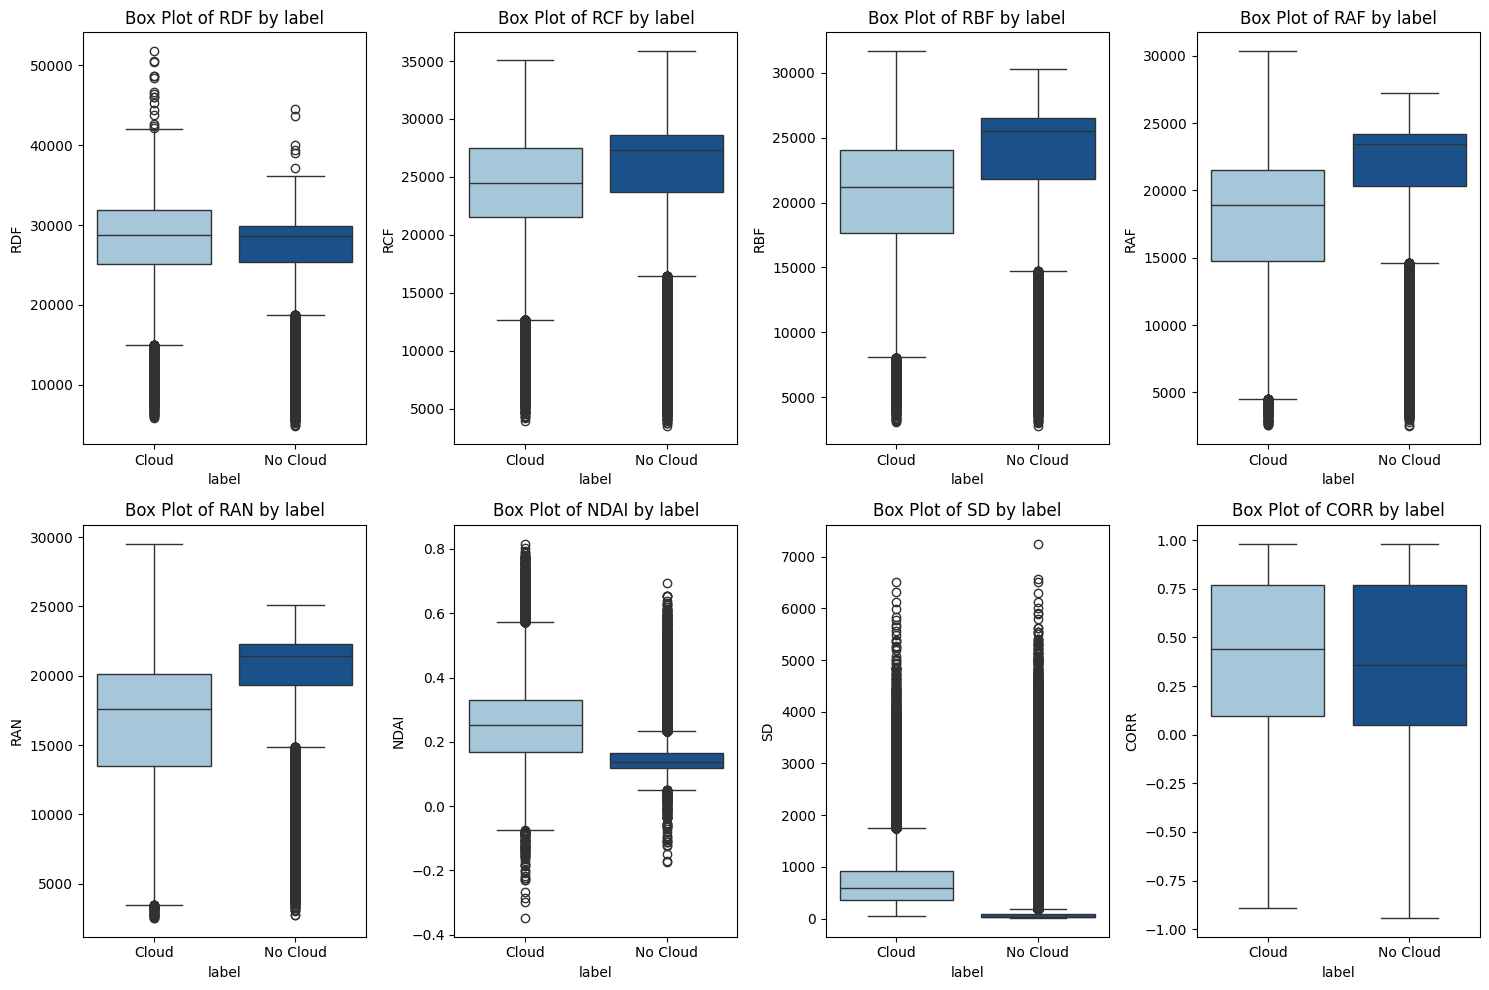

In [7]:
df_filtered = df_labeled[df_labeled['label'].isin([-1, 1])]
df_filtered['label'] = df_filtered['label'].map(label_names)
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_compare, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df_filtered['label'], y=df_filtered[col], hue=df_filtered['label'], palette=["#9ecae1", "#08519c"])
    plt.title(f'Box Plot of {col} by label')
    plt.xlabel('label')
    plt.ylabel(col)

plt.tight_layout()
plt.savefig('../figs/EDA/EDA03.png', bbox_inches='tight')
plt.show()

3. Splitting the test, validation, and test sets. 

In [8]:
# Check the class distribution of the original dataset
df_filtered['label'].value_counts(normalize=True)

label
No Cloud    0.610147
Cloud       0.389853
Name: proportion, dtype: float64

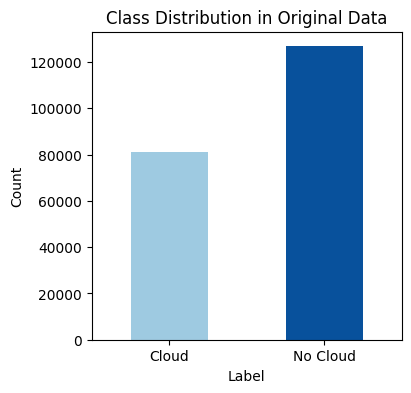

In [9]:
# Visualize the class distribution of the original dataset
plt.figure(figsize=(4, 4))
df_filtered['label'].value_counts().sort_index().plot(kind='bar',
         title='Class Distribution in Original Data', 
         color=["#9ecae1", "#08519c"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.savefig('../figs/EDA/EDA04.png', bbox_inches='tight')
plt.show()

In [10]:
df1 = intodf('O012791.npz') # train
df2 = intodf('O013490.npz') # train
df3 = intodf('O013257.npz') # test

def drop_unlabeled(dataf):
    df_new = dataf[dataf['label'] != 0]
    df_new['label'] = df_new['label'].map(label_names)
    return df_new

/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/2478219723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = df_new['label'].map(label_names)


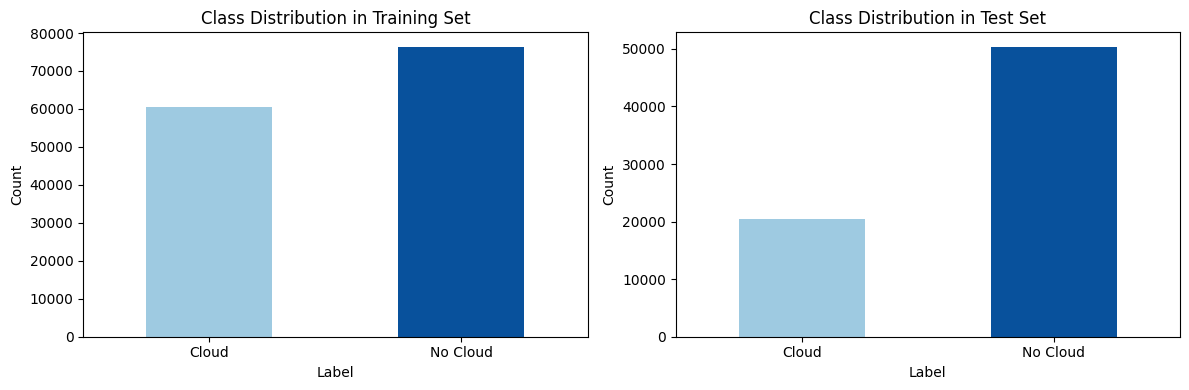

In [11]:
# Split the dataset into training and testing sets
df_test = drop_unlabeled(df3)
df_train = pd.concat([drop_unlabeled(df1), drop_unlabeled(df2)], axis=0)
X_train, X_test = df_train.iloc[:, 2:-1], df_test.iloc[:, 2:-1]
y_train, y_test = df_train['label'], df_test['label']


# Visualize the class distribution of the training and testing sets
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y_train.value_counts().sort_index().plot(kind='bar', title='Class Distribution in Training Set', color=["#9ecae1", "#08519c"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y_test.value_counts().sort_index().plot(kind='bar', title='Class Distribution in Test Set', color=["#9ecae1", "#08519c"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('../figs/EDA/EDA05.png', bbox_inches='tight')
plt.show()

/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/2478219723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = df_new['label'].map(label_names)
/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/2478219723.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = df_new['label'].map(label_names)


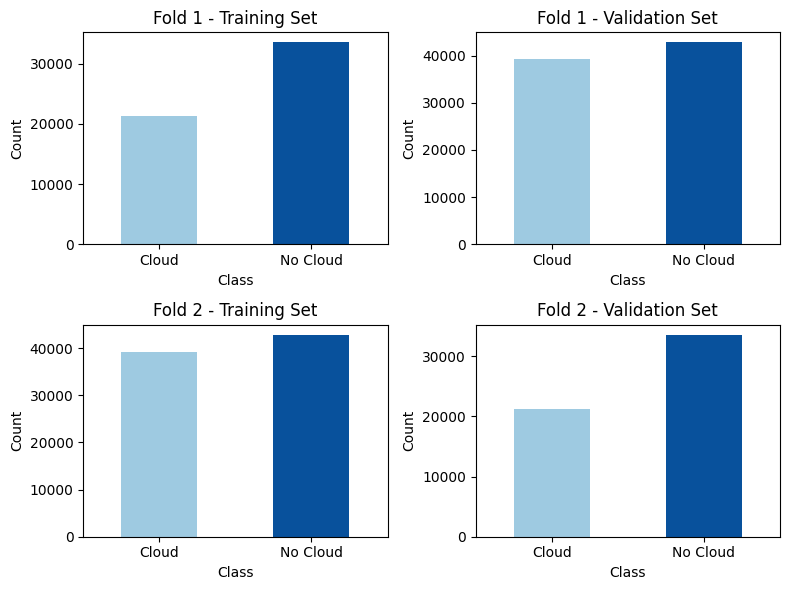

In [12]:
plt.figure(figsize=(8, 6))

# Fold 1: df1 as training set and df2 as validation set
X_train_fold, X_val_fold = drop_unlabeled(df1).iloc[:, 2:-1], drop_unlabeled(df2).iloc[:, 2:-1]
y_train_fold, y_val_fold = drop_unlabeled(df1)['label'], drop_unlabeled(df2)['label']

train_counts = y_train_fold.value_counts().sort_index()
val_counts = y_val_fold.value_counts().sort_index()

# Visualize
plt.subplot(2, 2, 1)
train_counts.plot(kind='bar', color=["#9ecae1", "#08519c"])
plt.title(f'Fold 1 - Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
val_counts.plot(kind='bar', color=["#9ecae1", "#08519c"])
plt.title(f'Fold 1 - Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Fold 2: df2 as training set and df1 as validation set
X_train_fold, X_val_fold = drop_unlabeled(df2).iloc[:, 2:-1], drop_unlabeled(df1).iloc[:, 2:-1]
y_train_fold, y_val_fold = drop_unlabeled(df2)['label'], drop_unlabeled(df1)['label']

train_counts = y_train_fold.value_counts().sort_index()
val_counts = y_val_fold.value_counts().sort_index()

# Visualize
plt.subplot(2, 2, 3)
train_counts.plot(kind='bar', color=["#9ecae1", "#08519c"])
plt.title(f'Fold 2 - Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(2, 2, 4)
val_counts.plot(kind='bar', color=["#9ecae1", "#08519c"])
plt.title(f'Fold 2 - Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('../figs/EDA/EDA06.png', bbox_inches='tight')
plt.show()

4. Data Cleansing: Additional EDA
- checking for NA values
- Check label distribution for each images
- PCA

In [13]:
df_labeled.isna().any().any()
#We can see there are no NA values

np.False_

In [14]:
df1 = intodf('O013257.npz')
df2 = intodf('O013490.npz')
df3 = intodf('O012791.npz')
dfs = [df1, df2, df3]

/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/3420091171.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/3420091171.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/29/9mp95kq92f30dj88d81_0mnm0000gn/T/ipykernel_55231/3420091171.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


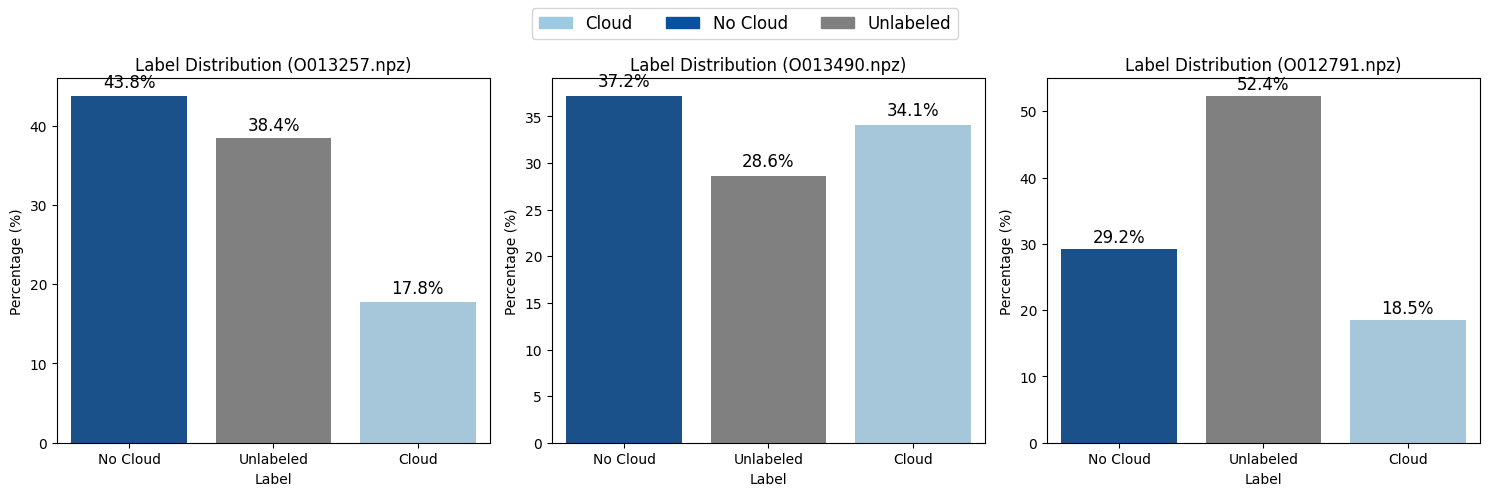

In [15]:
exp_files = ["O013257.npz", "O013490.npz", "O012791.npz"]

color_map = {1: "#9ecae1", -1: "#08519c", 0: "gray"}
label_names = {1: "Cloud", -1: "No Cloud", 0: "Unlabeled"}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, file in enumerate(exp_files):
    df = intodf(file)  # Load each file as a DataFrame
    labels = df["label"]  # Extract label column
    
    ax = axes[i]  # Select the correct subplot
    
    # Calculate percentages
    value_counts = labels.value_counts(normalize=True) * 100  # Get % instead of raw counts
    sorted_labels = sorted(value_counts.index)  # Ensure labels are sorted for color mapping
    
    # Plot countplot with percentages
    sns.barplot(
        x=sorted_labels, 
        y=value_counts[sorted_labels], 
        ax=ax, 
        palette=[color_map[label] for label in sorted_labels]
    )
    
    # Add text labels for percentages
    for j, val in enumerate(value_counts[sorted_labels]):
        ax.text(j, val + 1, f"{val:.1f}%", ha="center", fontsize=12)  # Add text above bars
    
    ax.set_xlabel("Label")
    ax.set_ylabel("Percentage (%)")
    ax.set_title(f"Label Distribution ({file})")
    ax.set_xticks(range(len(sorted_labels)))  # Ensure x-ticks match label order
    ax.set_xticklabels([label_names[lbl] for lbl in sorted_labels])  # Use human-readable names

# Create a global legend (outside the loop)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[l]) for l in label_names]
plt.figlegend(handles, label_names.values(), loc="upper center", fontsize=12, ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit legend
plt.savefig('../figs/EDA/EDA07.png', bbox_inches='tight')
plt.show()

We can see that the third picture has the most unlabeled labels. These unlabeled pixels are not useful for both test and train data, so we may exclude them while we are testing models. 

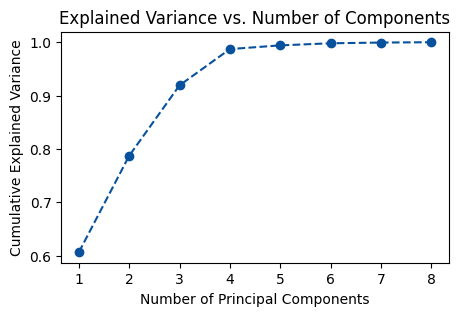

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = df_labeled.drop(columns=["X", "Y", "label"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

pca = PCA(n_components=features_scaled.shape[1])  # Use max possible components
pca.fit(features_scaled)

# Plot explained variance ratio
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color= "#08519c")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.savefig('../figs/EDA/EDA08.png', bbox_inches='tight')
plt.show()


In [17]:
pca = PCA(n_components=2)  # Reduce to 2D
principal_components = pca.fit_transform(features_scaled)

# Add PCA results to DataFrame
df_labeled["PCA1"] = principal_components[:, 0]
df_labeled["PCA2"] = principal_components[:, 1]

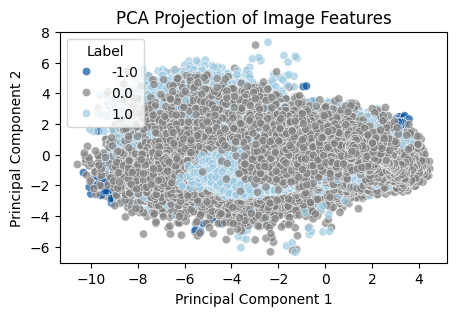

In [18]:
plt.figure(figsize=(5, 3))
sns.scatterplot(
    x=df_labeled["PCA1"], 
    y=df_labeled["PCA2"], 
    hue=df_labeled["label"], 
    palette={1: "#9ecae1", -1: "#08519c", 0: "gray"},  # Light blue for Cloud
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Image Features")
plt.legend(title="Label")
plt.savefig('../figs/EDA/EDA09.png', bbox_inches='tight')
plt.show()

- Cloud and No Cloud points are not fully separated, meaning that there is some overlap in PCA space.
- No Cloud points (-1) seem more spread out than Cloud points (1).
- PCA is capturing some structure, but separation between labels isn't perfect.
- The overlap suggests that the two features do not contain strong discriminative information.